# Model Performance Analysis

In [1]:
from configparser import ConfigParser
import yaml
import os
import pandas as pd
import matplotlib.pyplot as plt

from current_research_feature_effects.plotting.plots import boxplot_model_results

In [2]:
os.chdir("../")
config = ConfigParser()
config.read("config.ini")

['config.ini']

In [3]:
model_results_storage = config.get("storage", "model_results")
experiment_name = config.get("storage", "simulation_name")
with open(config.get("simulation_params", "datasets_yaml"), "r") as file:
    datasets_config = yaml.safe_load(file)
datasets = list(datasets_config.keys())
df = pd.DataFrame()
dfs = []
for dataset in datasets:
    df_temp = pd.read_sql_table(
        "model_results", f"sqlite:///experiments/{experiment_name}/{dataset}{model_results_storage}"
    )
    df_temp["dataset"] = dataset
    dfs.append(df_temp)
    df = pd.concat([df, df_temp]).drop(columns=["index"])

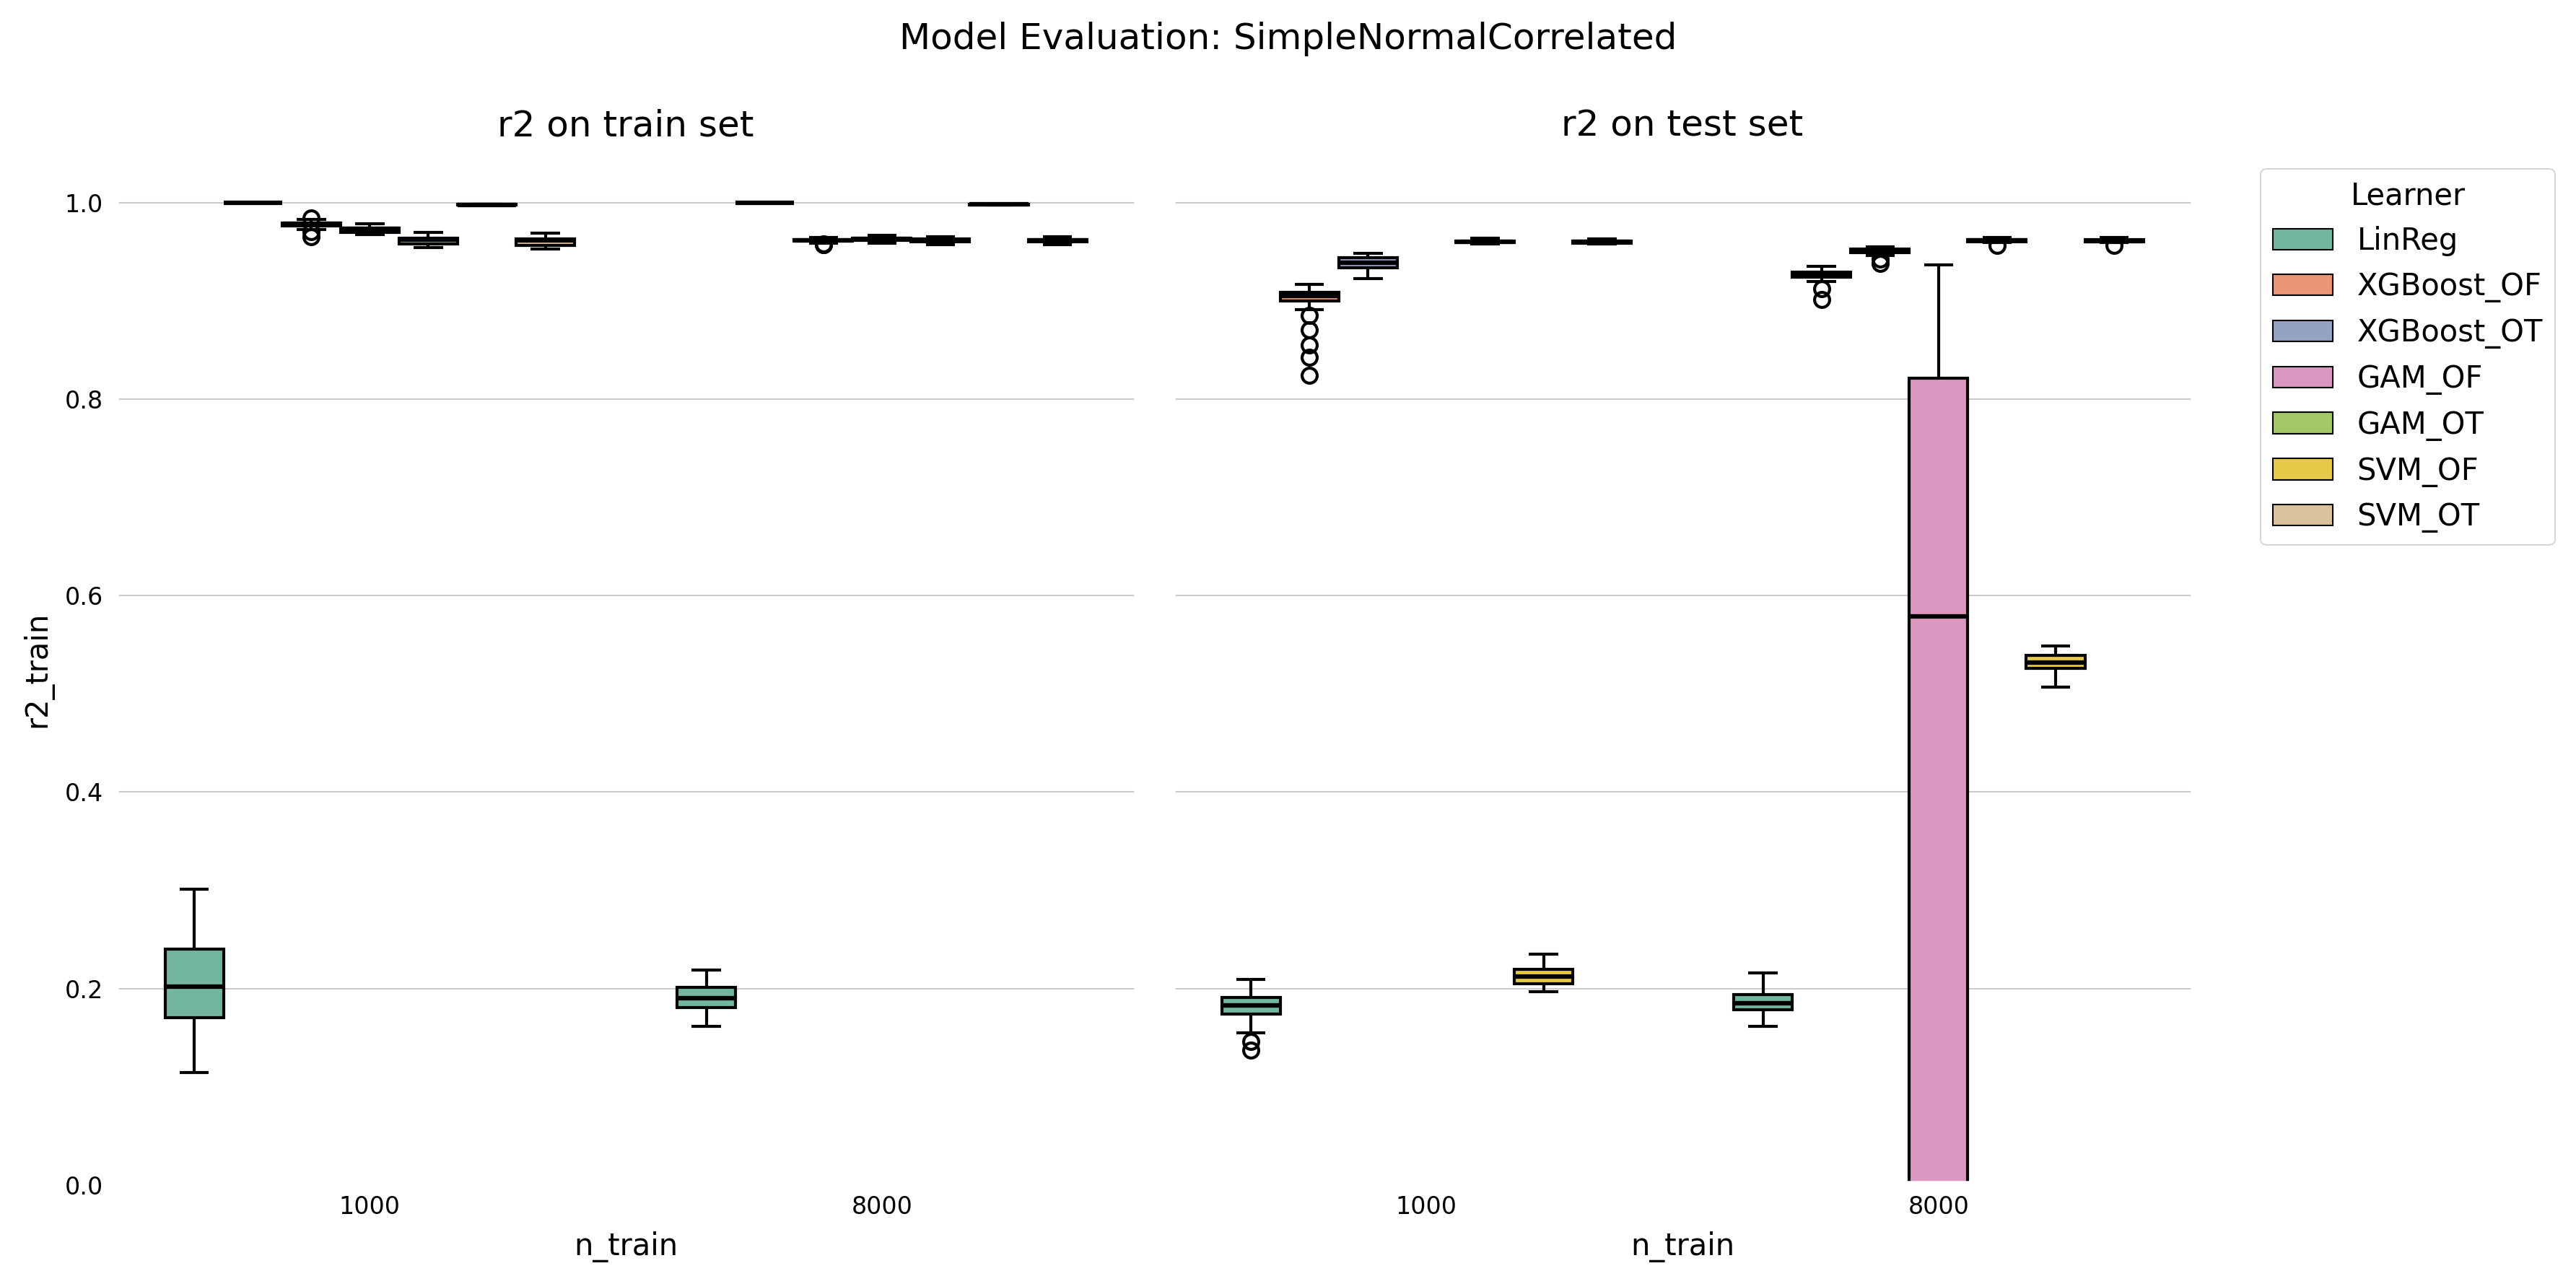

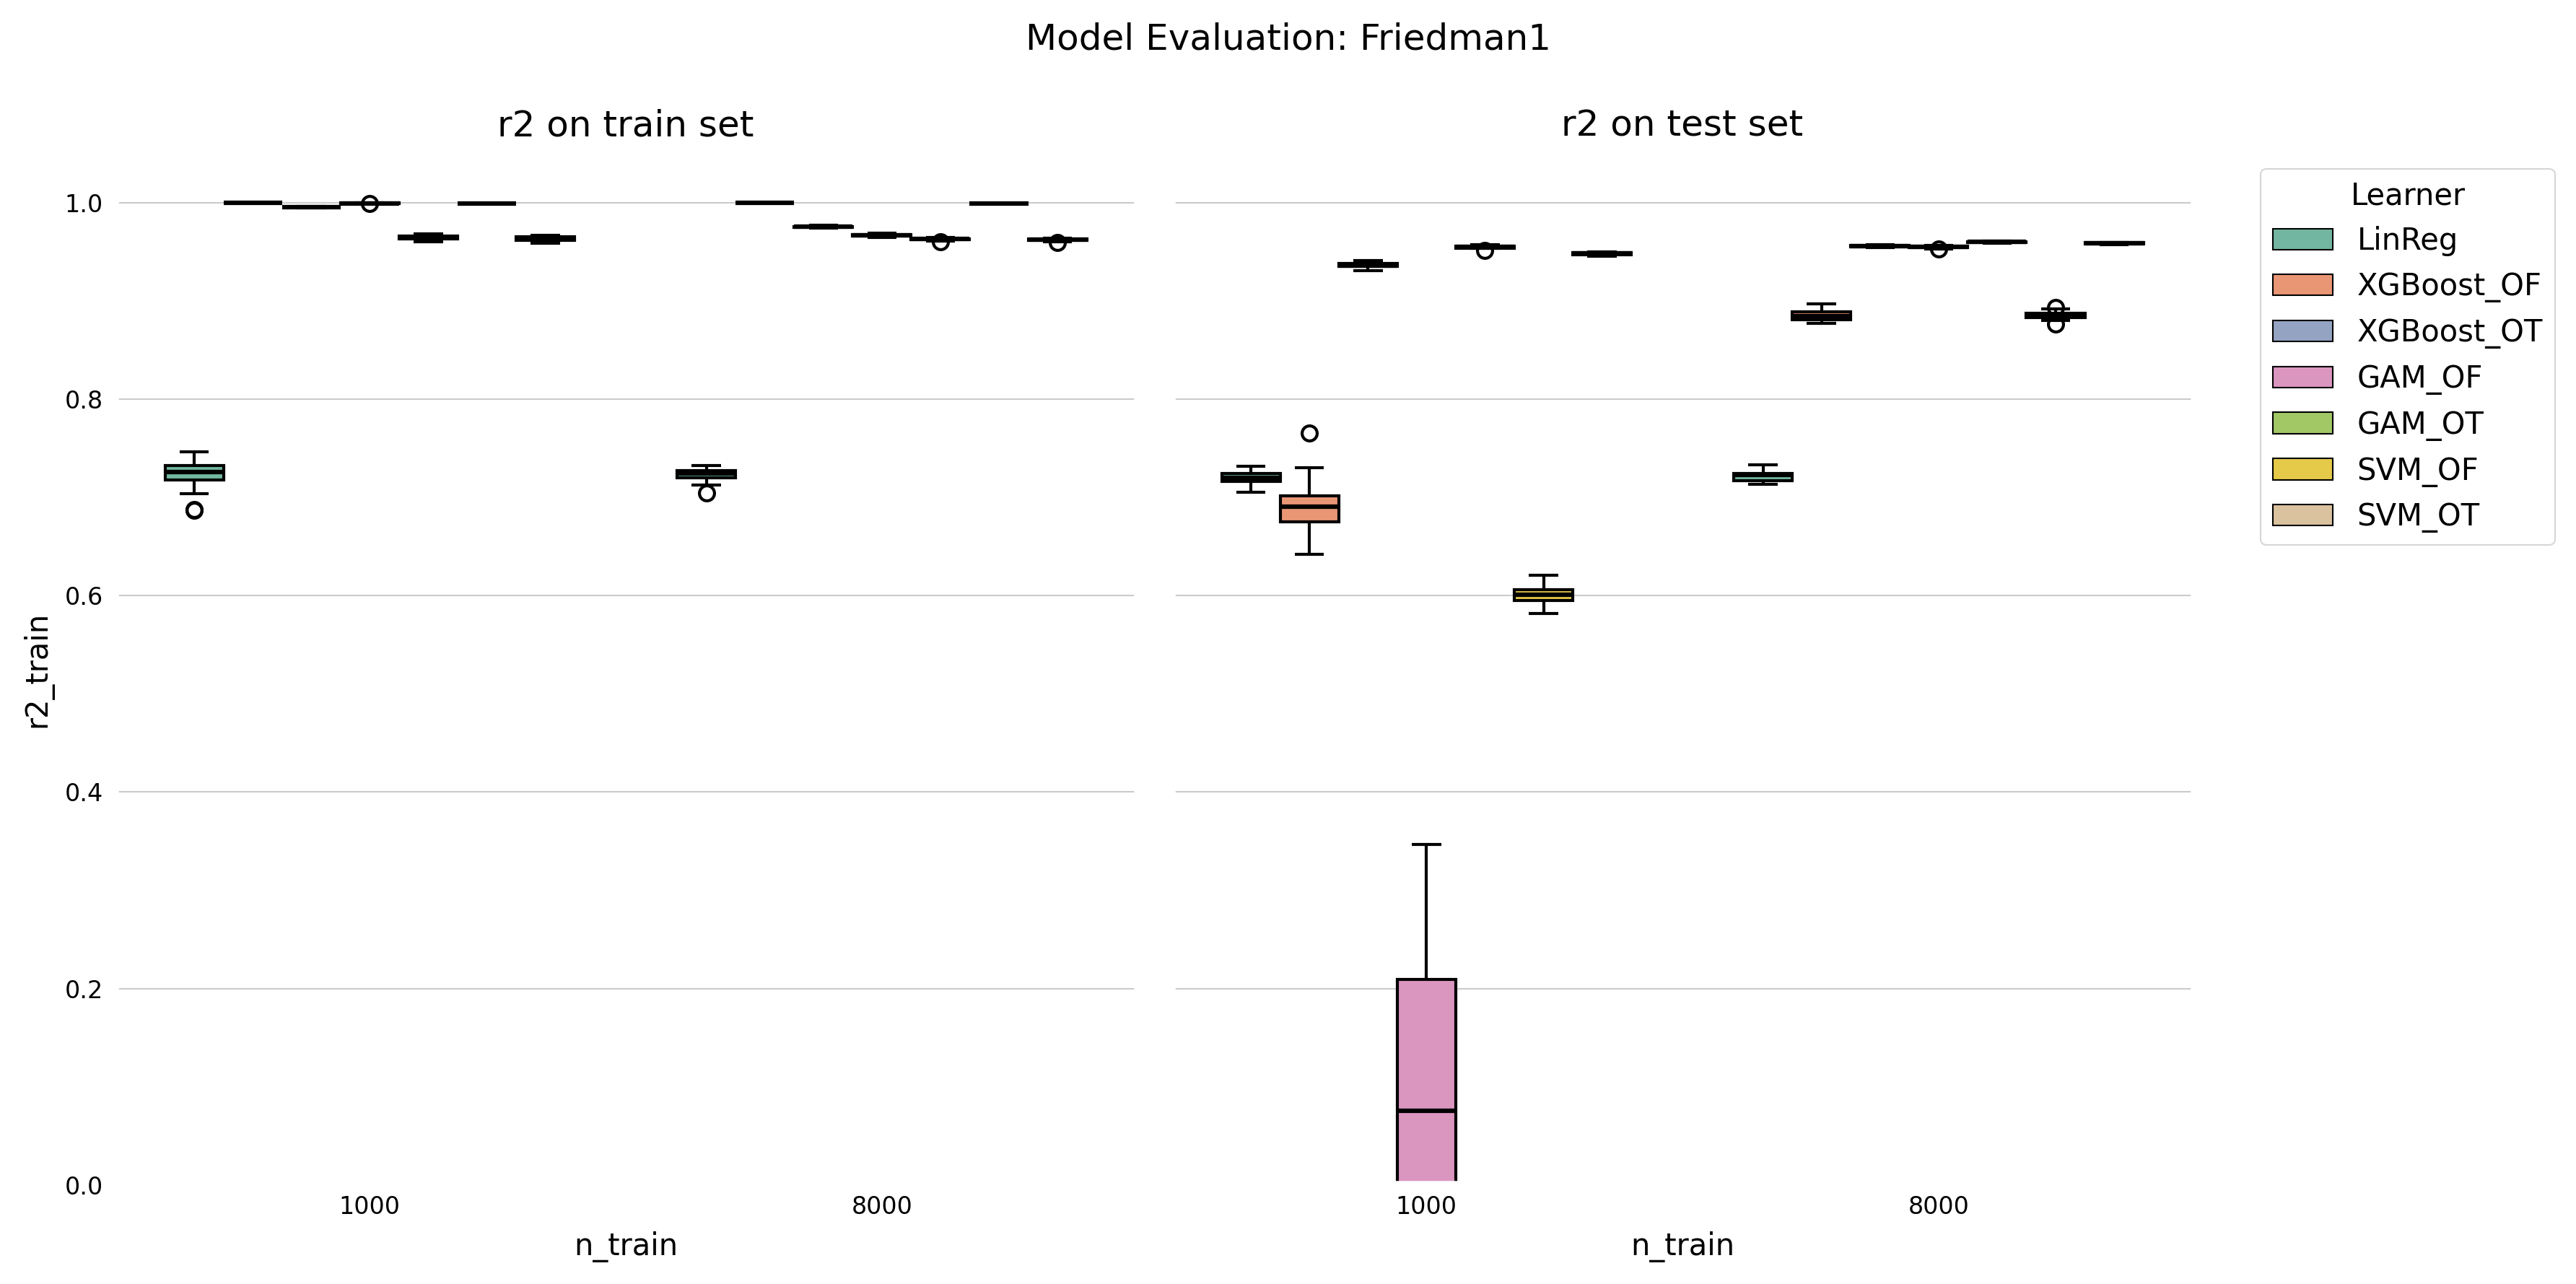

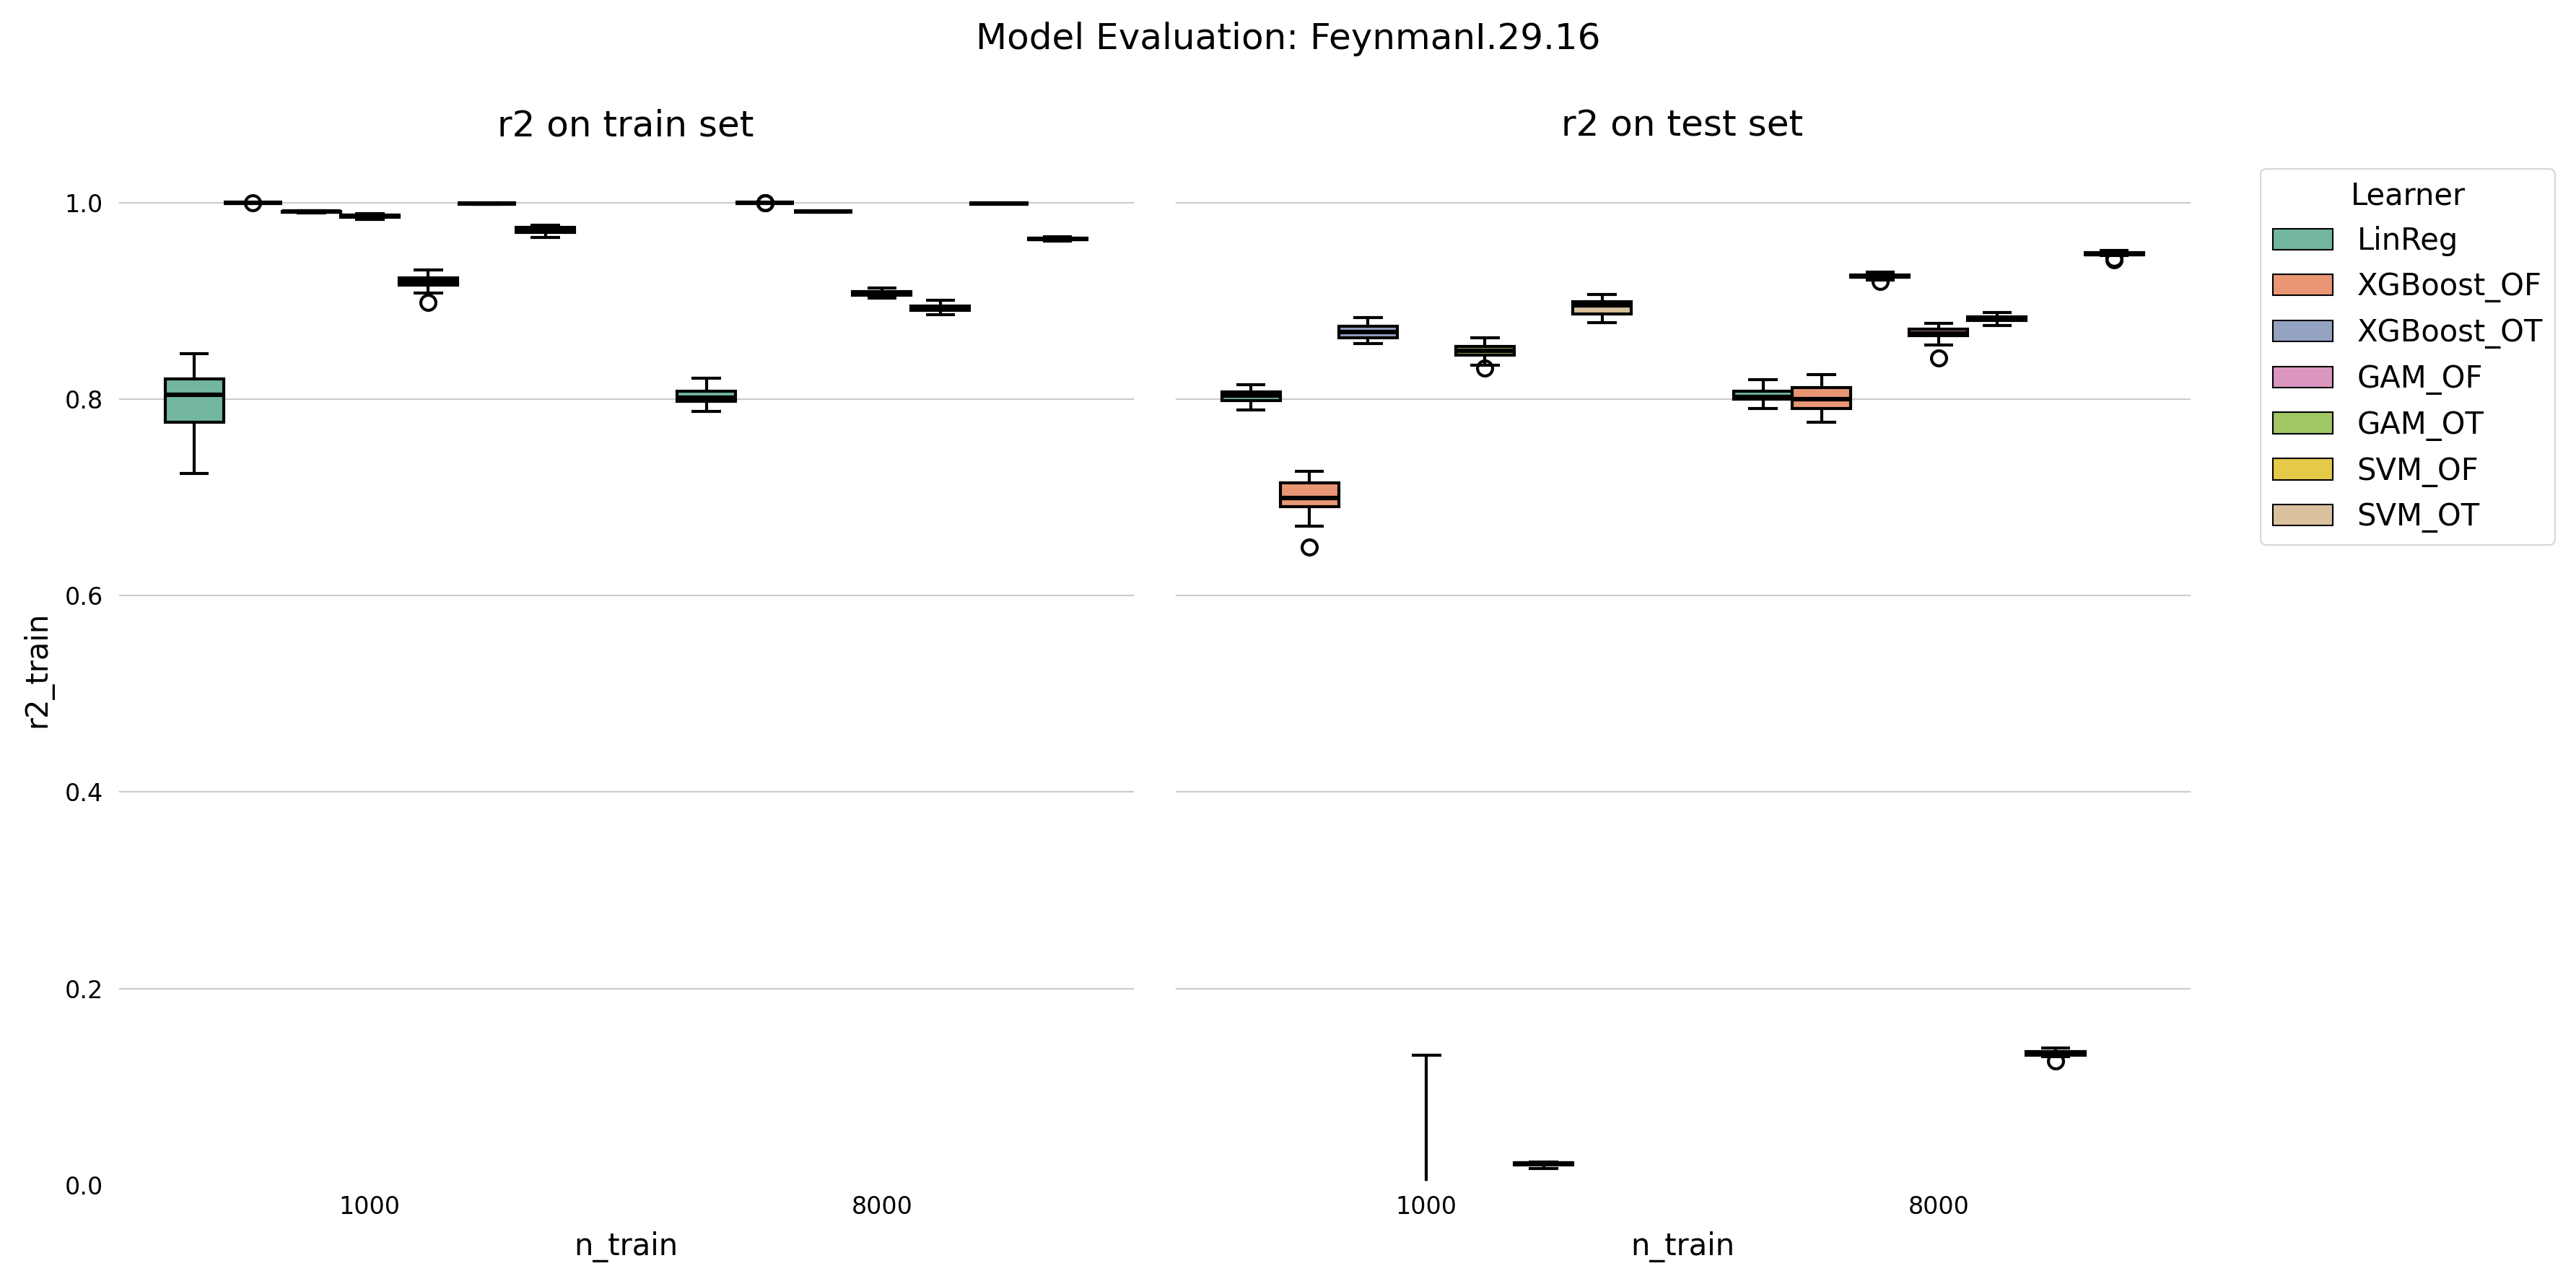

In [4]:
for df_, dataset in zip(dfs, datasets):
    boxplot_model_results(metric='r2', df=df_, ylim=(0, 1.05))
    plt.gcf().suptitle(f"Model Evaluation: {dataset}")

In [5]:
df_grouped = (
    df.groupby(["dataset", "n_train", "model"])
    .agg({"r2_train": ["mean", "std"], "r2_test": ["mean", "std"]})
    .round(4)
    .assign(
        r2_train=lambda x: x["r2_train"]["mean"].astype(str) + " ± " + x["r2_train"]["std"].astype(str),
        r2_test=lambda x: x["r2_test"]["mean"].astype(str) + " ± " + x["r2_test"]["std"].astype(str),
    )
    .droplevel(1, axis=1)
)
df_reshaped = (
    df_grouped.loc[:, ~df_grouped.columns.duplicated()]
    .reset_index()
    .pivot(columns="dataset", index=["n_train", "model"], values=["r2_train", "r2_test"])
    .reorder_levels([1, 0], axis=1)
    .reindex(
        columns=[
            ("SimpleNormalCorrelated", "r2_train"),
            ("SimpleNormalCorrelated", "r2_test"),
            ("Friedman1", "r2_train"),
            ("Friedman1", "r2_test"),
            ("FeynmanI.29.16", "r2_train"),
            ("FeynmanI.29.16", "r2_test"),
        ]
    )
)
df_reshaped

dataset            SimpleNormalCorrelated                      \
                                 r2_train             r2_test   
n_train model                                                   
1000    GAM_OF            0.9727 ± 0.0033  -22.7559 ± 33.1064   
        GAM_OT            0.9619 ± 0.0043     0.9603 ± 0.0013   
        LinReg            0.2027 ± 0.0482     0.1801 ± 0.0165   
        SVM_OF            0.9982 ± 0.0002     0.2133 ± 0.0104   
        SVM_OT            0.9606 ± 0.0045     0.9602 ± 0.0013   
        XGBoost_OF              1.0 ± 0.0     0.8972 ± 0.0215   
        XGBoost_OT         0.978 ± 0.0038     0.9383 ± 0.0066   
8000    GAM_OF             0.9631 ± 0.002    -0.1303 ± 2.0432   
        GAM_OT            0.9616 ± 0.0021     0.9615 ± 0.0016   
        LinReg            0.1913 ± 0.0138      0.187 ± 0.0153   
        SVM_OF            0.9982 ± 0.0001     0.5313 ± 0.0112   
        SVM_OT            0.9615 ± 0.0021     0.9614 ± 0.0016   
        XGBoost_OF              1.0 ± 0.0      0.926 ± 0.0065   
        XGBoost_OT        0.9615 ± 0.0019     0.9506 ± 0.0036   

dataset                   Friedman1                    FeynmanI.29.16  \
                           r2_train          r2_test         r2_train   
n_train model                                                           
1000    GAM_OF      0.9996 ± 0.0001  0.0685 ± 0.1844  0.9865 ± 0.0015   
        GAM_OT      0.9646 ± 0.0021  0.9549 ± 0.0011  0.9196 ± 0.0077   
        LinReg      0.7236 ± 0.0144  0.7199 ± 0.0064  0.7988 ± 0.0314   
        SVM_OF         0.9996 ± 0.0    0.6003 ± 0.01      0.999 ± 0.0   
        SVM_OT      0.9637 ± 0.0022  0.9485 ± 0.0012  0.9721 ± 0.0032   
        XGBoost_OF        1.0 ± 0.0   0.691 ± 0.0238        1.0 ± 0.0   
        XGBoost_OT  0.9956 ± 0.0003  0.9364 ± 0.0023   0.991 ± 0.0006   
8000    GAM_OF       0.9668 ± 0.001   0.9551 ± 0.001  0.9076 ± 0.0029   
        GAM_OT       0.9629 ± 0.001  0.9601 ± 0.0007  0.8928 ± 0.0037   
        LinReg      0.7232 ± 0.0067  0.7216 ± 0.0053  0.8025 ± 0.0084   
        SVM_OF         0.9996 ± 0.0  0.8853 ± 0.0036      0.999 ± 0.0   
        SVM_OT      0.9622 ± 0.0011  0.9588 ± 0.0006  0.9633 ± 0.0011   
        XGBoost_OF        1.0 ± 0.0  0.8854 ± 0.0053        1.0 ± 0.0   
        XGBoost_OT  0.9756 ± 0.0007  0.9562 ± 0.0009  0.9911 ± 0.0002   

dataset                               
                             r2_test  
n_train model                         
1000    GAM_OF      -0.9562 ± 1.1548  
        GAM_OT        0.849 ± 0.0075  
        LinReg       0.8025 ± 0.0075  
        SVM_OF       0.0212 ± 0.0018  
        SVM_OT       0.8937 ± 0.0081  
        XGBoost_OF   0.6998 ± 0.0181  
        XGBoost_OT     0.869 ± 0.007  
8000    GAM_OF       0.8669 ± 0.0067  
        GAM_OT        0.882 ± 0.0033  
        LinReg       0.8033 ± 0.0066  
        SVM_OF       0.1344 ± 0.0029  
        SVM_OT       0.9477 ± 0.0021  
        XGBoost_OF    0.801 ± 0.0129  
        XGBoost_OT   0.9254 ± 0.0023